### Stepik ML contest

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [4]:
events_train = pd.read_csv('https://stepik.org/media/attachments/course/4852/event_data_train.zip')
events_train.head()

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632


In [5]:
# description
# step_id - id стэпа
# user_id - анонимизированный id юзера
# timestamp - время наступления события в формате unix date
# action - событие, возможные значения:
# discovered - пользователь перешел на стэп
# viewed - просмотр шага,
# started_attempt - начало попытки решить шаг, ранее нужно было явно нажать на кнопку - начать решение, перед тем как приступить к решению практического шага
# passed - удачное решение практического шага

In [6]:
submissions_train = pd.read_csv('https://stepik.org/media/attachments/course/4852/submissions_data_train.zip')
submissions_train.head()

,step_id,timestamp,submission_status,user_id
0,31971,1434349275,correct,15853
1,31972,1434348300,correct,15853
2,31972,1478852149,wrong,15853
3,31972,1478852164,correct,15853
4,31976,1434348123,wrong,15853


In [7]:
# description
# step_id - id стэпа
# timestamp - время отправки решения в формате unix date
# submission_status - статус решения
# user_id - анонимизированный id юзера

### Data preparation

In [8]:
events_train['date'] = pd.to_datetime(events_train.timestamp, unit='s')
events_train.head()

,step_id,timestamp,action,user_id,date
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48
1,32815,1434340848,passed,17632,2015-06-15 04:00:48
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35


In [12]:
events_train['day'] = events_train.date.dt.date
events_train.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


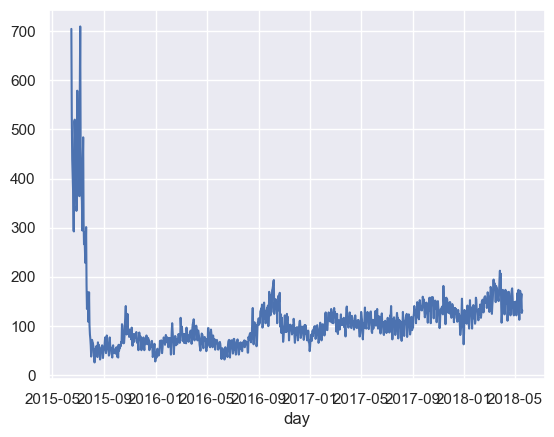

In [14]:
# считаем кол-во уникальных пользователей
events_train.groupby('day')['user_id'].nunique().plot()
plt.show()

array([[<AxesSubplot:title={'center':'passed_step'}>]], dtype=object)

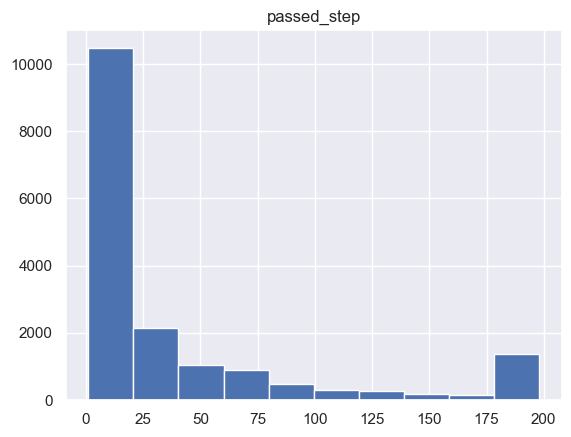

In [18]:
events_train[events_train.action == 'passed'].groupby('user_id').aggregate({'step_id': 'count'}).rename(columns={'step_id': 'passed_step'}).hist()

In [33]:
events_train.pivot_table(index='user_id', columns='action', values='step_id', aggfunc='count', fill_value=0).reset_index().head()

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,10
2,3,91,87,30,192
3,5,11,11,4,12
4,7,1,1,0,1


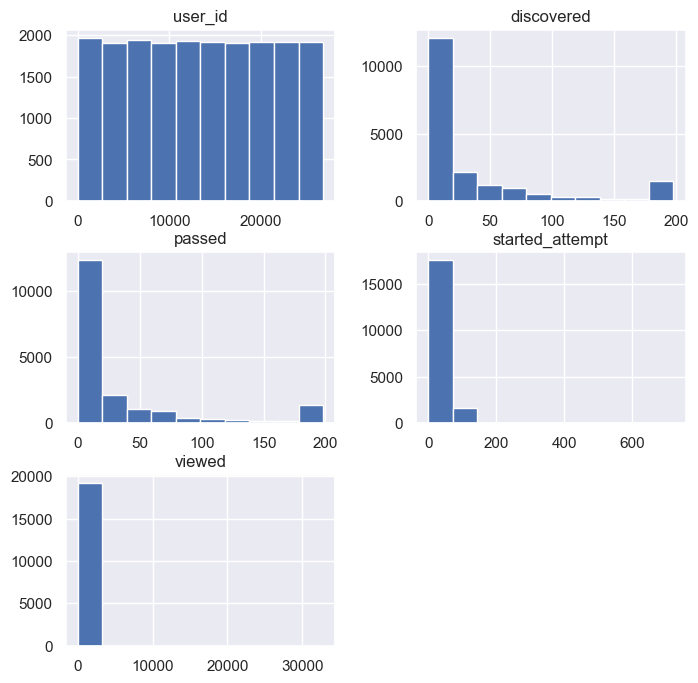

In [31]:
events_train.pivot_table(index='user_id', columns='action', values='step_id', aggfunc='count', fill_value=0).reset_index().hist(figsize=(8, 8))
plt.show()

In [34]:
submissions_train['date'] = pd.to_datetime(submissions_train.timestamp, unit='s')
submissions_train.head()

,step_id,timestamp,submission_status,user_id,date
0,31971,1434349275,correct,15853,2015-06-15 06:21:15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49
3,31972,1478852164,correct,15853,2016-11-11 08:16:04
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03


In [35]:
submissions_train['day'] = submissions_train.date.dt.date
submissions_train.head()

,step_id,timestamp,submission_status,user_id,date,day
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15


In [37]:
submissions_train.pivot_table(index='user_id', columns='submission_status', values='step_id', aggfunc='count', fill_value=0).reset_index().head()

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1


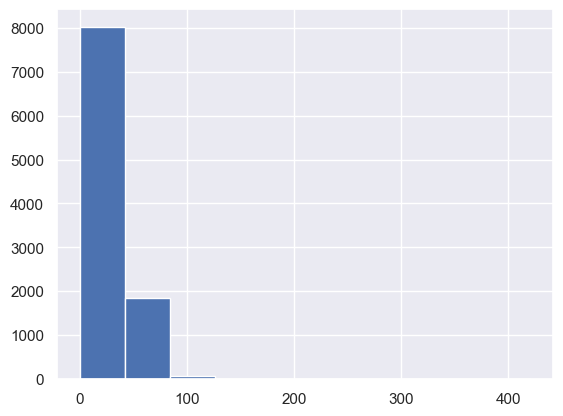

In [41]:
submissions_train.pivot_table(index='user_id', columns='submission_status', values='step_id', aggfunc='count', fill_value=0).reset_index().correct.hist()
plt.show()

### Задача
Отсечь пользователей, которые не закончили курс. Допустим, если пользователь не возвращался к курсу какое-то время, то с высокой вероятностью он уже не вернется для завершения курса.

**Шаг 1**
Найдем временные промежутки между прохождением степов, далее посмотрим в какой интервал укладывается большинство пользователей.

In [54]:
# для работы нам потребуется 3 колонки
visits_gap = events_train[['user_id', 'day', 'timestamp']]
visits_gap.head()

,user_id,day,timestamp
0,17632,2015-06-15,1434340848
1,17632,2015-06-15,1434340848
2,17632,2015-06-15,1434340848
3,17632,2015-06-15,1434340895
4,17632,2015-06-15,1434340895


In [55]:
# оставляем только уникальные записи timestamp в рамках одного пользователя и дня
visits_gap = visits_gap.drop_duplicates(subset=['user_id', 'day'])
visits_gap.head()

,user_id,day,timestamp
0,17632,2015-06-15,1434340848
36,12494,2015-06-15,1434341931
59,442,2015-06-15,1434342029
62,22254,2015-06-15,1434342042
94,6646,2015-06-15,1434342230


In [56]:
# создаем список с timestamp действий пользователя
visits_gap = visits_gap.groupby('user_id')['timestamp'].apply(list)
visits_gap.head()

user_id
1                                         [1472827464]
2                             [1514383364, 1519226966]
3    [1434358476, 1441257725, 1441440209, 144153391...
5                             [1466156809, 1499859621]
7                                         [1521634660]
Name: timestamp, dtype: object

In [57]:
# считаем разницу между событиями
visits_gap = visits_gap.apply(np.diff)
visits_gap.head()

user_id
1                                                  []
2                                           [4843602]
3    [6899249, 182484, 93710, 2768870, 171400, 78712]
5                                          [33702812]
7                                                  []
Name: timestamp, dtype: object

In [58]:
# извлекаем из серии значения
visits_gap = visits_gap.values
visits_gap

array([array([], dtype=int64), array([4843602]),
       array([6899249,  182484,   93710, 2768870,  171400,   78712]), ...,
       array([   86128,   136759,    94899,  1422583, 14347289,   505061,
                 98252,    57019])                                       ,
       array([1567990]), array([], dtype=int64)], dtype=object)

In [59]:
# трансформируем события в плоский список
visits_gap = pd.Series(np.concatenate(visits_gap, axis=0))
visits_gap

0         4843602
1         6899249
2          182484
3           93710
4         2768870
           ...   
97867    14347289
97868      505061
97869       98252
97870       57019
97871     1567990
Length: 97872, dtype: int64

In [62]:
# меняем формат в дни
visits_gap = visits_gap / (24 * 60 * 60)

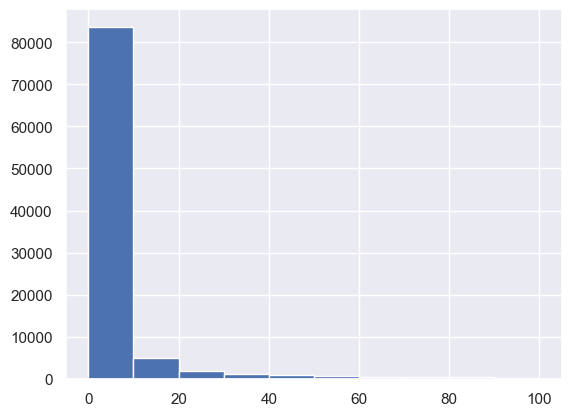

In [64]:
# строим гистограмму
visits_gap[visits_gap < 100].hist()
plt.show()

In [67]:
# смотрим в какой интервал времени укладывается 90% событий
visits_gap.quantile(0.90)

18.325995370370403

In [112]:
is_gone_time_gap = visits_gap.quantile(0.90)

**Шаг 2**
Смержим наши данные в таблицу и дополним ее необходимыми значениями

In [158]:
events_pivot = events_train.pivot_table(index='user_id', columns='action', values='step_id', aggfunc='count', fill_value=0).reset_index()
events_pivot.head()

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,10
2,3,91,87,30,192
3,5,11,11,4,12
4,7,1,1,0,1


In [159]:
submissions_pivot = submissions_train.pivot_table(index='user_id', columns='submission_status', values='step_id', aggfunc='count', fill_value=0).reset_index()
submissions_pivot.head()

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1


In [160]:
users_data = events_pivot.merge(submissions_pivot, on='user_id', how='outer')
users_data = users_data.fillna(0)
users_data.head()

,user_id,discovered,passed,started_attempt,viewed,correct,wrong
0,1,1,0,0,1,0.0,0.0
1,2,9,9,2,10,2.0,0.0
2,3,91,87,30,192,29.0,23.0
3,5,11,11,4,12,2.0,2.0
4,7,1,1,0,1,0.0,0.0


In [161]:
last_timestamp = events_train[['user_id','timestamp']].groupby('user_id').aggregate({'timestamp':'max'}).reset_index().rename(columns={'timestamp': 'last_timestamp'})

In [162]:
last_timestamp.head()

,user_id,last_timestamp
0,1,1472827464
1,2,1519226966
2,3,1444581588
3,5,1499859939
4,7,1521634660


In [163]:
users_data = users_data.merge(last_timestamp, on='user_id', how='outer').fillna(0)
users_data.head()

,user_id,discovered,passed,started_attempt,viewed,correct,wrong,last_timestamp
0,1,1,0,0,1,0.0,0.0,1472827464
1,2,9,9,2,10,2.0,0.0,1519226966
2,3,91,87,30,192,29.0,23.0,1444581588
3,5,11,11,4,12,2.0,2.0,1499859939
4,7,1,1,0,1,0.0,0.0,1521634660


In [164]:
now_t = users_data.last_timestamp.max()
now_t

1526772811

In [165]:
users_data['is_gone'] = now_t - users_data['last_timestamp']  > is_gone_time_gap
users_data.head()

,user_id,discovered,passed,started_attempt,viewed,correct,wrong,last_timestamp,is_gone
0,1,1,0,0,1,0.0,0.0,1472827464,True
1,2,9,9,2,10,2.0,0.0,1519226966,True
2,3,91,87,30,192,29.0,23.0,1444581588,True
3,5,11,11,4,12,2.0,2.0,1499859939,True
4,7,1,1,0,1,0.0,0.0,1521634660,True


In [166]:
users_data['course_completed'] = users_data.passed > 170
users_data.head()

,user_id,discovered,passed,started_attempt,viewed,correct,wrong,last_timestamp,is_gone,course_completed
0,1,1,0,0,1,0.0,0.0,1472827464,True,False
1,2,9,9,2,10,2.0,0.0,1519226966,True,False
2,3,91,87,30,192,29.0,23.0,1444581588,True,False
3,5,11,11,4,12,2.0,2.0,1499859939,True,False
4,7,1,1,0,1,0.0,0.0,1521634660,True,False


In [168]:
users_data.groupby('course_completed').count()

,user_id,discovered,passed,started_attempt,viewed,correct,wrong,last_timestamp,is_gone
course_completed,,,,,,,,,
False,17809,17809,17809,17809,17809,17809,17809,17809,17809
True,1425,1425,1425,1425,1425,1425,1425,1425,1425


### Задача
Как я уже писал ранее, данные, с которыми мы работаем, обезличены, тоесть реальные id пользователей заменены случайным числом. Анонимизация пользовательских данных - очень важная тема для Data Science. С одной стороны мы хотим знать о поведении наших пользователей как можно больше, с другой стороны нам важно соблюдать приватность наших пользователей.

Поэтому данные о поведении пользователей анонимизируют не только когда речь идет об открытых данных, но и при работе с данными внутри компании. Не заметили сколько писем вам недавно пришло об изменении политики конфеденциальности, хотите узнать почему? В комментарии приложена ссылка на очень интересный доклад об этой проблеме.

А пока что вот вам хакерская задача, за каким вымышленным id скрывается Анатолий Карпов - автор курса, данные которого мы анализируем?

Введите id Анатолия Карпова, под которым он фигурирует в данных events_data_train и submissions_data_train.

In [136]:
events_train.groupby('user_id').aggregate({'action': 'count'})

,action
user_id,
1,2
2,30
3,400
5,38
7,3
...,...
26790,26
26793,3
26794,352


In [68]:
events_train.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


In [73]:
events_train[events_train.user_id == 20907].timestamp.min()

1434346645

In [74]:
events_train[events_train.user_id == 20907].timestamp.max()

1453480839

In [75]:
gap = events_train[events_train.user_id == 20907].timestamp.max() - events_train[events_train.user_id == 20907].timestamp.min()
gap = gap / (24 * 60 * 60)
gap

221.4605787037037

In [97]:
gap = events_train[events_train.action == 'viewed']

In [98]:
max_timestamp = gap.groupby('user_id').timestamp.apply(list).apply(max)

In [99]:
min_timestamp = gap.groupby('user_id').timestamp.apply(list).apply(min)

In [103]:
gap_t = pd.concat([min_timestamp, max_timestamp], axis=1, ignore_index=True)
gap_t.head()

,0,1
user_id,,
1,1472827464,1472827464
2,1514383364,1519226966
3,1434358476,1444581588
5,1466156809,1499859939
7,1521634660,1521634660


In [104]:
gap_t['gap'] = gap_t[1] - gap_t[0]
gap_t

,0,1,gap
user_id,,,
1,1472827464,1472827464,0
2,1514383364,1519226966,4843602
3,1434358476,1444581588,10223112
5,1466156809,1499859939,33703130
7,1521634660,1521634660,0
...,...,...,...
26790,1451484016,1517495987,66011971
26793,1510225031,1510225031,0
26794,1495287049,1512035039,16747990


In [111]:
unique_days = events_train.groupby('user_id')['day'].nunique()
unique_days

user_id
1        1
2        2
3        7
5        2
7        1
        ..
26790    4
26793    1
26794    9
26797    2
26798    1
Name: day, Length: 19234, dtype: int64